In [94]:
import argparse
from tqdm import tqdm, trange
from torch.utils.data import DataLoader, RandomSampler, DistributedSampler

import os
import sys

from source.dataset import get_raw_datasets, NewsDataset
from transformers import AdamW, get_linear_schedule_with_warmup

from transformers import RobertaConfig, RobertaTokenizer, RobertaModel

from help import *
from tensorboardX import SummaryWriter
from source.extractor_model import EvidenceSelection

import json

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [95]:
text = """
In this subsection, we aim to split the sea of wisdom into two
competing parties, and extract respective evidences for subsequent
comparison. As the only available supervised data is the veracity
label of the claim, we conduct a temporary veracity prediction
to detect salient evidences for both parties via a veracity scoring
module. Each claim is assigned a temporary veracity label in {false,
half, true} based on its real veracity, where “half” indicates that the
claim contains both true and false aspects.

"""

In [96]:
from transformers import RobertaTokenizer

MODEL_CLASSES = {
    "roberta": [RobertaConfig, RobertaTokenizer, EvidenceSelection],
}

config_class, tokenizer_class, model_class = MODEL_CLASSES["roberta"]
config = config_class.from_pretrained("roberta-base")
config.correlation_method = "mlp"
config.cls_loss_weight = 0.9

roberta = RobertaModel.from_pretrained("roberta-base", config=config)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [97]:
def encoder(input_ids, attention_mask=None, token_type_ids=None):
    outputs = roberta(input_ids, attention_mask=attention_mask)    # CHECK
    pooled_output = outputs[1]  # [CLS]
    return pooled_output

In [98]:
tokenizer = tokenizer_class.from_pretrained("roberta-base", do_lower_case=True)


/home/lonk/miniconda3/envs/efnd/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [99]:
tokens=tokenizer(text, return_tensors='pt', padding=True, truncation=True)
tokens

{'input_ids': tensor([[    0, 50118,  1121,    42, 45845,     6,    52,  4374,     7,  3462,
             5,  3342,     9, 12320,    88,    80, 50118, 11828, 16382,  1799,
             6,     8, 14660,  7091, 42925,  8457,    13,  7757, 50118,   175,
          5489,  4060,     4,   287,     5,   129,   577, 20589,   414,    16,
             5,  4342, 18583, 50118, 33480,     9,     5,  2026,     6,    52,
          2883,    10,  4667,  4342, 18583, 16782, 50118,   560, 10933, 41159,
         42925,  8457,    13,   258,  1799,  1241,    10,  4342, 18583,  2314,
         50118, 48095,     4,  4028,  2026,    16,  5530,    10,  4667,  4342,
         18583,  6929,    11, 25522, 22303,     6, 50118,  4809,     6,  1528,
         24303,   716,    15,    63,   588,  4342, 18583,     6,   147,    44,
            48,  4809,    17,    46,  8711,    14,     5, 50118, 31628,  6308,
           258,  1528,     8,  3950,  5894,     4, 50140,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1

In [106]:
pooled= encoder(input_ids=tokens['input_ids'], attention_mask=tokens['attention_mask'])
pooled[0].tolist()

[-0.29414117336273193,
 -0.09332390874624252,
 -0.2172388732433319,
 -0.3527851998806,
 -0.2385692596435547,
 -0.08361361920833588,
 0.069534070789814,
 -0.11371437460184097,
 0.240836963057518,
 -0.19188131392002106,
 0.11910303682088852,
 -0.18632999062538147,
 -0.07651906460523605,
 0.03609667718410492,
 0.39672917127609253,
 -0.03678528219461441,
 0.19250929355621338,
 0.151863694190979,
 0.2774311602115631,
 0.1011573001742363,
 -0.05772455409169197,
 -0.07223163545131683,
 -0.14177539944648743,
 -0.10207319259643555,
 -0.26921671628952026,
 -0.11652358621358871,
 0.016594763845205307,
 0.08932521939277649,
 0.13249464333057404,
 0.20627743005752563,
 0.11003176122903824,
 -0.18586379289627075,
 0.45509541034698486,
 -0.4132956564426422,
 -0.04321639984846115,
 0.18671809136867523,
 -0.3633582890033722,
 -0.07754646986722946,
 0.028823014348745346,
 -0.12383534014225006,
 -0.10436984896659851,
 -0.014400088228285313,
 -0.1409282386302948,
 -0.1592378169298172,
 0.16731631755828857

In [107]:
def tokenize_and_encode(text):
    tokens = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    pooled = encoder(input_ids=tokens['input_ids'], attention_mask=tokens['attention_mask'])
    return pooled[0].tolist()

# Loading the reports of a claim into a pandas DataFrame

The steps include:
1. Load the json file into a dictionary
2. Extract the reports from the dictionary
3. Load the reports into a pandas DataFrame, at the same time encode the text

The dataframe looks like this (excluding the encodings and other columns with long content):
|    | text                                                                                                                                                                                                                                                                                                         |   is_evidence |
|---:|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|--------------:|
|  0 | The nonprofit , Southwest Key Programs Inc. , be to be pay more than $ 458 million in fiscal 2018 , accord to the data — the most among the organization , government agency and company that run a detention and care system for immigrant child on behalf of the Department of Health and Human Services . |             1 |
|  1 | The Trump administration plan to pay a Texas nonprofit nearly half a billion dollar this year to care for immigrant child who be detain cross the U.S. border illegally , accord to government data .                                                                                                        |             1 |
|  2 | Southwest Key rapidly increase the compensation of it CEO , Juan Sanchez , from about $ 269,000 in 2010 to more than $ 786,000 in 2015 , the most recent year for which it tax return be available through the website Guidestar.org .                                                                       |             0 |
|  3 | The company own at least one other local building also lease by Southwest Key , a former hospital convert into a detention center for immigrant child in 2013 , accord to the Brownsville Herald .                                                                                                           |             0 |
|  4 | His compensation nearly double to $ 1.5 million in 2016 , accord to tax record for an Austin charter school he found .                                                                                                                                                                                       |             0 |


In [108]:
print(df.loc[:, "text": "is_evidence"].head(5).to_markdown())

|    | text                                                                                                                                                                                                                                                                                                         |   is_evidence |
|---:|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|--------------:|
|  0 | The nonprofit , Southwest Key Programs Inc. , be to be pay more than $ 458 million in fiscal 2018 , accord to the data — the most among the organization , government agency and company that run a detention and care system for immigrant child on behalf of the Department of Health and Human Services . |             1 |
|  1 | The Trump admin

In [109]:
import json
# read datasets/RAWFC/train/150241.json

with open('datasets/RAWFC/train/150241.json') as f:
    json_data = json.load(f)
    
json_data

{'event_id': '150241',
 'claim': 'The Trump administration is paying Southwest Key $458 million to run immigrant child detention centers, and its CEO earns a $1.5 million salary.',
 'original_label': 'true',
 'label': 'true',
 'explain': 'In late June 2018, a series of investigative news reports exposed the fact that Juan Sanchez, the chief executive of non-profit Southwest Key, was making a salary of $1.5 million while his organization had scored $458 million in federal grants to shelter detained children who had been taken from their parents at the southern U.S. border.The reports came amid widespread outrage over U.S. President Donald Trump’s “zero tolerance” immigration policy and as viral stories often do, resulted in a number of memes that spread throughout social media:Although memes are not always factual, the one shared by actor Samuel Jackson is. The figures were taken from a 19 June 2018\xa0 report:We independently confirmed with tax records publicly available through the no

In [119]:
import pandas as pd

# Define an empty list to store sentences and evidence values
data = []

# Access the claim section of the JSON
claim = json_data["claim"]

# Loop through each report in the "reports" section
for report in json_data["reports"]:
  # Extract the content (text) and tokenized sentences from the report
#   content = report["content"]
  sentences = report["tokenized"]

  # Iterate through each sentence in the report
  for sentence in sentences:
    text = sentence["sent"]
    is_evidence = sentence["is_evidence"]

    encodings = tokenize_and_encode(text)

    # Append the sentence and evidence value to the data list
    data.append({"text": text, "is_evidence": is_evidence, "encodings": encodings})

# Create a pandas DataFrame from the data list
df = pd.DataFrame(data)

# # Add the claim text as the first row
# df.loc[-1, "text"] = claim
# df.loc[-1, "is_evidence"] = "Claim"

df

,text,is_evidence,encodings
0,"The nonprofit , Southwest Key Programs Inc. , ...",1,"[-0.30485159158706665, -0.06543225049972534, -..."
1,The Trump administration plan to pay a Texas n...,1,"[-0.3080664873123169, -0.07783979177474976, -0..."
2,Southwest Key rapidly increase the compensatio...,0,"[-0.3128407299518585, -0.050968557596206665, -..."
3,The company own at least one other local build...,0,"[-0.3224104046821594, -0.06008109077811241, -0..."
4,His compensation nearly double to $ 1.5 millio...,0,"[-0.30638012290000916, -0.06146285682916641, -..."
...,...,...,...
136,A large nonprofit organization with about a do...,0,"[-0.30893832445144653, -0.07302109152078629, -..."
137,"The organization , whose top executive , NAME ...",0,"[-0.3045176863670349, -0.07933331280946732, -0..."
138,That ’ s the big contract in the system of gov...,0,"[-0.3168739974498749, -0.07714288681745529, -0..."
139,Southwest Key Programs — which run 26 other sh...,0,"[-0.3109998106956482, -0.06403704732656479, -0..."


# Dimension reduction

Need to look more into the algorithm, the idea is to reduce the dimension of the data to make it easier to work with.

In [111]:
import numpy as np
from sklearn.decomposition import PCA

encodings_all = np.array(df["encodings"].tolist())

pca = PCA(n_components=2)
new_pooled = pca.fit_transform(encodings_all)
print(new_pooled.shape)

df["pca1"] = new_pooled[:, 0]
df["pca2"] = new_pooled[:, 1]

df

(141, 2)


,text,is_evidence,encodings,pca1,pca2
0,"The nonprofit , Southwest Key Programs Inc. , ...",1,"[-0.30485159158706665, -0.06543225049972534, -...",-0.103689,0.045288
1,The Trump administration plan to pay a Texas n...,1,"[-0.3080664873123169, -0.07783979177474976, -0...",0.055157,0.053407
2,Southwest Key rapidly increase the compensatio...,0,"[-0.3128407299518585, -0.050968557596206665, -...",-0.123296,-0.095865
3,The company own at least one other local build...,0,"[-0.3224104046821594, -0.06008109077811241, -0...",-0.048036,0.039833
4,His compensation nearly double to $ 1.5 millio...,0,"[-0.30638012290000916, -0.06146285682916641, -...",-0.025165,-0.127867
...,...,...,...,...,...
136,A large nonprofit organization with about a do...,0,"[-0.30893832445144653, -0.07302109152078629, -...",-0.072019,-0.027369
137,"The organization , whose top executive , NAME ...",0,"[-0.3045176863670349, -0.07933331280946732, -0...",-0.129818,-0.009389
138,That ’ s the big contract in the system of gov...,0,"[-0.3168739974498749, -0.07714288681745529, -0...",-0.033437,0.115477
139,Southwest Key Programs — which run 26 other sh...,0,"[-0.3109998106956482, -0.06403704732656479, -0...",0.046897,0.009509


# Cluster the encoded reports

The idea is to cluster the encoded reports to see if there are any patterns in the data.
 
`KMeans` is used to cluster the data. Probably need to look more into the algorithm.

/home/lonk/miniconda3/envs/efnd/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


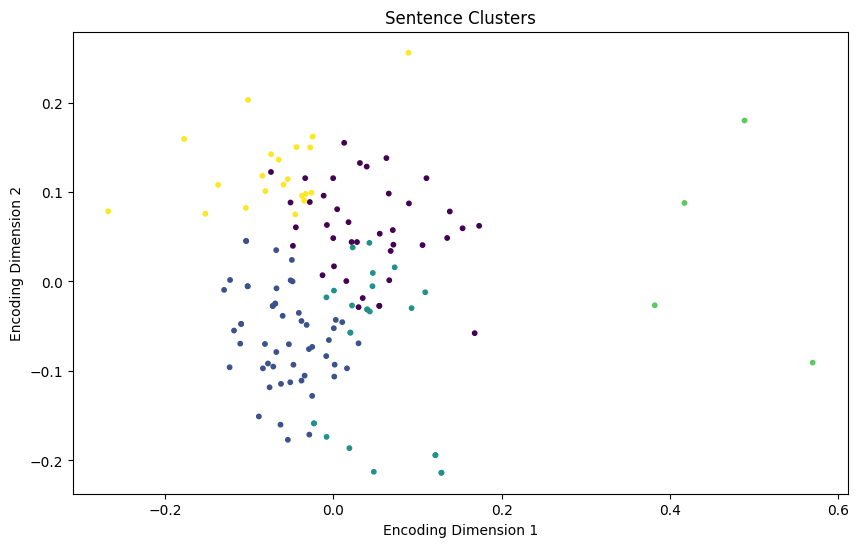

In [116]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assuming you have a DataFrame with columns "text", "is_evidence", and "encoded_sentence"

# Create a K-means clustering model
kmeans = KMeans(n_clusters=5)  # Adjust the number of clusters as needed

# Fit the model to the encoded sentences
kmeans.fit(df["encodings"].tolist())

# Add the cluster labels to the DataFrame
df["cluster"] = kmeans.labels_

# Visualize the clusters, downsizing the encodings to 2D using PCA or t-SNE
plt.figure(figsize=(10, 6))
plt.scatter(df["pca1"], df["pca2"], c=df["cluster"], cmap="viridis", s=10)

plt.xlabel("Encoding Dimension 1")
plt.ylabel("Encoding Dimension 2")
plt.title("Sentence Clusters")
plt.show()

In [117]:
df

,text,is_evidence,encodings,pca1,pca2,cluster
0,"The nonprofit , Southwest Key Programs Inc. , ...",1,"[-0.30485159158706665, -0.06543225049972534, -...",-0.103689,0.045288,1
1,The Trump administration plan to pay a Texas n...,1,"[-0.3080664873123169, -0.07783979177474976, -0...",0.055157,0.053407,0
2,Southwest Key rapidly increase the compensatio...,0,"[-0.3128407299518585, -0.050968557596206665, -...",-0.123296,-0.095865,1
3,The company own at least one other local build...,0,"[-0.3224104046821594, -0.06008109077811241, -0...",-0.048036,0.039833,0
4,His compensation nearly double to $ 1.5 millio...,0,"[-0.30638012290000916, -0.06146285682916641, -...",-0.025165,-0.127867,1
...,...,...,...,...,...,...
136,A large nonprofit organization with about a do...,0,"[-0.30893832445144653, -0.07302109152078629, -...",-0.072019,-0.027369,1
137,"The organization , whose top executive , NAME ...",0,"[-0.3045176863670349, -0.07933331280946732, -0...",-0.129818,-0.009389,1
138,That ’ s the big contract in the system of gov...,0,"[-0.3168739974498749, -0.07714288681745529, -0...",-0.033437,0.115477,0
139,Southwest Key Programs — which run 26 other sh...,0,"[-0.3109998106956482, -0.06403704732656479, -0...",0.046897,0.009509,2
